In [1508]:
"""
Created on Tuesday 1 May 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
import warnings
warnings.simplefilter("ignore")

### Load the subject and stiumuls repect to their speed

### Subjects

In [2072]:
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/six_deg.csv'
data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

data_hc = data[['x1_PD001','y1_PD001']] # change the ID each subject code(e.g PD001 or PD003)
y_data = data_hc[data_hc.columns[0]]
x_data = data_hc[data_hc.columns[1]]

#### For stimulus

In [2073]:
#import CSV data
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/6_degSti.xlsx'
data_path = os.path.join(dirname,data_file)
rawdata = pd.read_excel(data_path)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

### Trigonometric functions

In [2074]:
# Trigonometric functions

# Define the function
def func(x, a, b, c):  #Position as a function of time.
    return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

#initial guesses( This has to change depend on stimulus speed)
#for 1 degree per second: [10, 0.05, 0]
#for 2 degrees per second: [10, 0.1, 0]
#for 4 degrees per second: [10, 0.2, 0]
#for 6 degrees per second: [10, 0.3, 0]
#for 8 degrees per second: [10, 0.4, 0]
InitialGuess = [10, 0.3, 0] # for one degree

# Perform curve fitting
popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

# Extract the optimal values of a, b, and c
a, b, c = popt
# print("a =", a)
# print("b =", b)
# print("c =", c)

# Fit the curve
fit_time = func(y_data,a,b,c)
# plt.plot(y_data,fit_time)
# plt.show()


### Find the residual

In [2075]:
# Different(aka residual)
diff = x_data - fit_time

dt_array = np.array(diff)
dt_array = pd.DataFrame(dt_array,columns=['diff'])
window_size = 2
dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()
#plt.plot(y_data,dt_array['Moving_Average'])
# create dataframe
data = {'Time':y_data,'POS':dt_array['Moving_Average']}
df = pd.DataFrame(data)

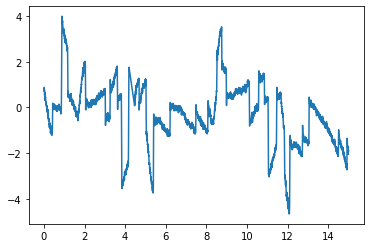

In [2076]:
import matplotlib.pyplot as plt
plt.plot(y_data,dt_array['Moving_Average'])

#### The whole dataset

In [2077]:
# Plot specific range
x_start = 1.66
x_end = 15.0

# Filter the data points within the disired range using boolean indexing
mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
x_data_range = df.loc[mask]

data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
df_test = pd.DataFrame(data)

### Determine the integration window

In [2078]:
# Determine the integration window
def check_sign(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"
df_test['Sign'] = df_test['POS'].apply(check_sign)

In [2079]:
df_test.to_csv('df_test_post_neg.csv')

### Condition of the window

In [2080]:
# Condition window width 
def calculate_start_end(row):
    global last_positive, last_negative
    if row['Sign'] == 'Positive':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
            last_positive = row['Time']
            return last_positive, '', '', ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
            pos_end = row['Time']
            last_positive = ''
            return '', pos_end, '', ''
        else:
            return '', '', '', ''
    elif row['Sign'] == 'Negative':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', last_negative, ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', '', last_negative
        else:
            return '', '', '', ''
    else:
        return '', '', '', ''

# Initialize the last positive and negative values to empty strings 
last_positive = ''
last_negative = ''

# Reset the index of the DataFrame
df_test = df_test.reset_index(drop=True)

# Apply the custom function to create new columns
df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

# Fill the empty cells with an empty string
df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

# Print the resulting dataframe 
#print(df_test)

#### Positive Time Start Trimming

In [2081]:
# Select the non-empty values in the 'Pos_Start' column
pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_pos_start_values = []
for value in pos_start_values:
    rounded_pos_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
postim_start_values = np.array(rounded_pos_start_values)

# Print the non-empty values
#print(postim_start_values)

### Remove spikes consective values

In [2082]:
#  input array
arr = postim_start_values 

# Set the threshold for difference between consecutive values
threshold = 0.1

# Create an empty list to store the filtered values
filtered_values = [arr[0]]

# Iterate through the array, comparing consecutive values
for i in range(1, len(arr)):
    if abs(arr[i] - arr[i - 1]) >= threshold:
        filtered_values.append(arr[i])

# Convert the filtered values list back to a NumPy array
filtered_arr = np.array(filtered_values)

postim_start_values = filtered_arr

print(postim_start_values)

[ 1.73  2.05  2.2   2.33  3.25  3.63  4.17  4.7   6.21  7.48  8.07  8.43
 10.39 11.46 13.06 13.22]


#### Poisitive Time end Trimming

In [2083]:
# Select the non-empty values in the 'Pos_End' column
pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

# Round the values in the 'Pos_End' column to two decimal places
rounded_pos_end_values = []
for value in pos_end_values:
    rounded_pos_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
postim_end_values = np.array(rounded_pos_end_values)

# Print the non-empty values
#print(postim_end_values)

### Remove spikes consective values

In [2084]:
#  input array
arr = postim_end_values 

# Set the threshold for difference between consecutive values
threshold = 0.1

# Create an empty list to store the filtered values
filtered_values = [arr[0]]

# Iterate through the array, comparing consecutive values
for i in range(1, len(arr)):
    if abs(arr[i] - arr[i - 1]) >= threshold:
        filtered_values.append(arr[i])

# Convert the filtered values list back to a NumPy array
filtered_arr = np.array(filtered_values)

postim_end_values = filtered_arr

print(postim_end_values)

[ 2.03  2.18  2.31  3.    3.6   3.79  4.67  5.01  6.21  7.47  8.07 10.1
 10.41 11.02 11.69 13.2 ]


### Reload the raw data for mapping

In [2085]:
# Reload the raw data for mapping
data = data_hc.rename(columns={data_hc.columns.values[0]:"Position",
                               data_hc.columns.values[1]:'Time'})

#### Map the start positive Time to POS in raw data

In [2086]:
# Create a dictionary from the mapping list
mapping_list = postim_start_values

# Map the values to the 'POS' column in raw
mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']

#### Map the End positive Time to POS in raw data

In [2087]:
# Create a dictionary from the mapping list
mapping_list = postim_end_values

# Map the values to the 'POS' column in raw
mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']


#### Velocity param positive dataframe

In [2088]:
# # column miss match
# Check lengths and truncate longer column 
if len(postim_start_values) > len(mapped_posSt): 
    postim_start_values = postim_start_values[:len(mapped_posSt)] 
elif len(mapped_posSt) > len(postim_start_values):
    mapped_posSt = mapped_posSt[:len(postim_start_values)]      

# Now columns have equal length 
data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
param_vel_start = pd.DataFrame(data_param)

data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_positive_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_positive_final['Del_X'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']

# Remove short duration from 50 to 70
#param_vel_positive_final = param_vel_positive_final[(param_vel_positive_final['Del_X'] > 0.3) & 
 #                                                   (param_vel_positive_final['Del_X'] < 1.5)]
#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Del_X'] < 2.07]
#                                                     (param_vel_positive_final['Del_X'] < 2.07)]

#param_vel_positive_final = param_vel_positive_final.fillna(method='ffill')
#param_gain_final
#param_vel_positive_final


In [2089]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,1.73,9.6976,2.03,9.5766,0.30
1,2.05,7.3387,2.18,7.0565,0.13
2,2.20,6.7137,2.31,6.4718,0.11
3,2.33,5.9476,3.00,2.8629,0.67
4,3.25,0.1613,3.60,0.1210,0.35
5,3.63,-1.6129,3.79,-2.0565,0.16
6,4.17,-4.9194,4.67,-6.7339,0.50
7,4.70,-8.0040,5.01,-8.8105,0.31
8,6.21,-3.4274,6.21,-3.4274,0.00
9,7.48,4.3952,7.47,3.8508,-0.01


In [2090]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X
0,1.73,9.6976,2.03,9.5766,0.30
1,2.05,7.3387,2.18,7.0565,0.13
2,2.20,6.7137,2.31,6.4718,0.11
3,2.33,5.9476,3.00,2.8629,0.67
4,3.25,0.1613,3.60,0.1210,0.35
5,3.63,-1.6129,3.79,-2.0565,0.16
6,4.17,-4.9194,4.67,-6.7339,0.50
7,4.70,-8.0040,5.01,-8.8105,0.31
8,6.21,-3.4274,6.21,-3.4274,0.00
9,7.48,4.3952,7.47,3.8508,-0.01


#### Conditions

In [2091]:
param_vel_positive_final['Condition'] = param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1']
param_vel_positive_final['Condition'] =abs(param_vel_positive_final['Condition'])
#param_vel_positive_final = param_vel_positive_final[param_vel_positive_final['Condition'] > 0.72]

In [2092]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X,Condition
0,1.73,9.6976,2.03,9.5766,0.30,0.30
1,2.05,7.3387,2.18,7.0565,0.13,0.13
2,2.20,6.7137,2.31,6.4718,0.11,0.11
3,2.33,5.9476,3.00,2.8629,0.67,0.67
4,3.25,0.1613,3.60,0.1210,0.35,0.35
5,3.63,-1.6129,3.79,-2.0565,0.16,0.16
6,4.17,-4.9194,4.67,-6.7339,0.50,0.50
7,4.70,-8.0040,5.01,-8.8105,0.31,0.31
8,6.21,-3.4274,6.21,-3.4274,0.00,0.00
9,7.48,4.3952,7.47,3.8508,-0.01,0.01


### Velocity for Positive peak calculation

In [2093]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

# abs
param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

# Reindexing
param_vel_positive_final = param_vel_positive_final.reset_index(drop=True)

# Remove unwant values
#param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

# Calculate the average slope
average_positive_slope = abs(param_vel_positive_final['slope'].mean())

# Print the average slope
#print(average_positive_slope)

In [2094]:
param_vel_positive_final 

,positive_x1,positive_y1,positive_x2,positive_y2,Del_X,Condition,slope
0,1.73,9.6976,2.03,9.5766,0.30,0.30,0.403333
1,2.05,7.3387,2.18,7.0565,0.13,0.13,2.170769
2,2.20,6.7137,2.31,6.4718,0.11,0.11,2.199091
3,2.33,5.9476,3.00,2.8629,0.67,0.67,4.604030
4,3.25,0.1613,3.60,0.1210,0.35,0.35,0.115143
5,3.63,-1.6129,3.79,-2.0565,0.16,0.16,2.772500
6,4.17,-4.9194,4.67,-6.7339,0.50,0.50,3.629000
7,4.70,-8.0040,5.01,-8.8105,0.31,0.31,2.601613
8,6.21,-3.4274,6.21,-3.4274,0.00,0.00,NaN
9,7.48,4.3952,7.47,3.8508,-0.01,0.01,54.440000


#### Negative Time Start Trimming

In [2095]:
# Select the non-empty values in the 'Pos_Start' column
neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_start_values = []
for value in neg_start_values:
    rounded_neg_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
negtim_start_values = np.array(rounded_neg_start_values)

# Print the non-empty values
#print(negtim_start_values)

### Remove spikes consective values

In [2096]:
#  input array
arr = negtim_start_values 

# Set the threshold for difference between consecutive values
threshold = 0.1

# Create an empty list to store the filtered values
filtered_values = [arr[0]]

# Iterate through the array, comparing consecutive values
for i in range(1, len(arr)):
    if abs(arr[i] - arr[i - 1]) >= threshold:
        filtered_values.append(arr[i])

# Convert the filtered values list back to a NumPy array
filtered_arr = np.array(filtered_values)

negtim_start_values = filtered_arr

print(negtim_start_values)

[ 1.66  2.05  2.2   2.33  3.02  3.62  3.81  4.69  5.03  6.23  7.49  8.09
 10.12 10.4  11.04 11.71 13.22]


#### Negative Time End Trimming

In [2097]:
# Select the non-empty values in the 'Pos_Start' column
neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_end_values = []
for value in neg_end_values:
    rounded_neg_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
negtim_end_values = np.array(rounded_neg_end_values)

# Print the non-empty values
#print(negtim_end_values)

### Remove spikes consective values

In [2098]:
#  input array
arr = negtim_end_values 

# Set the threshold for difference between consecutive values
threshold = 0.1

# Create an empty list to store the filtered values
filtered_values = [arr[0]]

# Iterate through the array, comparing consecutive values
for i in range(1, len(arr)):
    if abs(arr[i] - arr[i - 1]) >= threshold:
        filtered_values.append(arr[i])

# Convert the filtered values list back to a NumPy array
filtered_arr = np.array(filtered_values)

negtim_end_values = filtered_arr

print(negtim_end_values)

[ 1.71  2.03  3.23  4.15  4.68  6.19  6.38  7.46  8.05  8.41 10.37 11.44
 13.04 13.28]


#### Map the start negative Time to POS in raw data

In [2099]:
# Create a dictionary from the mapping list
mapping_list = negtim_start_values

# Map the values to the 'POS' column in raw
mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']

#### Map the End of negative Time to POS in raw data

In [2100]:
# Create a dictionary from the mapping list
mapping_list = negtim_end_values

# Map the values to the 'POS' column in raw
mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']

#### Velocity param negative dataframe

In [2101]:
# column miss match
# Check lengths and truncate longer column 
if len(negtim_start_values) > len(mapped_negSt): 
    negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
elif len(mapped_negSt) > len(negtim_start_values):
    mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
param_vel_start = pd.DataFrame(data_param)
data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_negative_final['Del_X'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
#param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
#param_vel_negative_final

# Remove short duration
# param_vel_negative_final = param_vel_negative_final[(param_vel_negative_final['Del_X'] > 0.3) & 
#                                                     (param_vel_negative_final['Del_X'] < 2.07)]
#param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Del_X'] < 1.5]
#                                                     


In [2102]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X
0,1.66,9.3347,1.71,9.5766,0.05
1,2.05,7.3387,2.03,9.5766,-0.02
2,2.20,6.7137,3.23,0.1008,1.03
3,2.33,5.9476,4.15,-7.3387,1.82
4,3.02,1.7339,4.68,-6.8347,1.66
5,3.62,-1.5323,6.19,-4.0927,2.57
6,3.81,-2.3589,6.38,-1.7540,2.57
7,4.69,-8.0645,7.46,3.6492,2.77
8,5.03,-9.7984,8.05,7.2379,3.02
9,6.23,-2.7016,8.41,9.4153,2.18


#### Conditions

In [2103]:
param_vel_negative_final['Condition'] = param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1']
param_vel_negative_final['Condition'] =abs(param_vel_negative_final['Condition'])
param_vel_negative_final = param_vel_negative_final[param_vel_negative_final['Condition'] > 1.01]

### Velocity for Negative peak calculation

In [2104]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2']
                                     - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] 
                                     - param_vel_negative_final['negative_x1'])

# abs
param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Reindexing
param_vel_negative_final = param_vel_negative_final.reset_index(drop=True)

# Remove unwant values
#param_gain_negative_final.loc[(param_gain_negative_final['slope'] < 0.80) |  
#                              (param_gain_negative_final['slope'] > 1.09), 
#                              'slope'] = np.nan
# Calculate the average slope
average_negative_slope = abs(param_vel_negative_final['slope'].mean())

# Print the average slope
#print(average_negative_slope)

In [2105]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,Del_X,Condition,slope
0,2.20,6.7137,3.23,0.1008,1.03,1.03,6.420291
1,2.33,5.9476,4.15,-7.3387,1.82,1.82,7.300165
2,3.02,1.7339,4.68,-6.8347,1.66,1.66,5.161807
3,3.62,-1.5323,6.19,-4.0927,2.57,2.57,0.996265
4,3.81,-2.3589,6.38,-1.7540,2.57,2.57,0.235370
5,4.69,-8.0645,7.46,3.6492,2.77,2.77,4.228773
6,5.03,-9.7984,8.05,7.2379,3.02,3.02,5.641159
7,6.23,-2.7016,8.41,9.4153,2.18,2.18,5.558211
8,7.49,4.9798,10.37,-2.3185,2.88,2.88,2.534132
9,8.09,8.4274,11.44,-10.4234,3.35,3.35,5.627104


In [2106]:
average_negative_slope

3.7820784784993773

### Total velocity for both positive and negative

In [2107]:
final_Vel = pd.concat([param_vel_positive_final[['Del_X','slope']],
                       param_vel_negative_final[['Del_X','slope']]], axis=0, join='outer')

In [2108]:
final_Vel

,Del_X,slope
0,0.30,0.403333
1,0.13,2.170769
2,0.11,2.199091
3,0.67,4.604030
4,0.35,0.115143
5,0.16,2.772500
6,0.50,3.629000
7,0.31,2.601613
8,0.00,NaN
9,-0.01,54.440000


### Counter check with duration and velocity

In [2109]:
final_Vel['Checked_velocity'] = final_Vel['slope'] * final_Vel['Del_X']
Vel = final_Vel['Checked_velocity'].sum()/final_Vel['Del_X'].sum()
Vel

3.360003122073058

In [2110]:
duration = final_Vel['Del_X'].sum()
print("The total duration is: ",duration)

The total duration is:  32.02999999999999


### Calculate Gain

In [2111]:
speed = 6 # stimulus speed
total_gain = Vel/speed
print("The gain for this subject is:",total_gain)

The gain for this subject is: 0.5600005203455097
